# Style Transfer

### "venue of development": Arts & Hedonism

Neural networks sound too far away from us and most of us will never know how it works or write codes about it, not to mention that training a network costs too much time and effort.

However there are many pre-built models that we can play with them with little knowledge or following the tutorial.

For example, today I want to introduce style transfer with tensorflow pre-built models. Style Transfer is to transform images/pictures with some art styles. It needs a content image and a style image, and then it will transform the content image with the style learned from the style image. (Example images are given below.)

There are many pre-built models provided by the tensorflow about style transfer. There is a fully-built model (https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) which requieds no training time and knowledge about it. However, it cannot be modified/fitted to our own images, and it works well with only a few styles.

In this notebook, I use the other two models, which are the prediction and transform steps. It allows me to build my own model and train it with my own images. At the same time, it is also a black box (no need to fully understand how it works).

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# the urls for Tensorflow Models
style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 
                                             'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 
                                               'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

class style_transfer_model():
    def __init__(self, content_path, style_path):
        """
        load and transform the style images and content images
        calculate bottlenecks of style images and content images
        """
        # preprocess the images
        self.content_image = self.load_transform_img(content_path, 384)
        self.style_image = self.load_transform_img(style_path, 256)
        # calculate the bottlenecks
        self.style_bottleneck = self.style_predict(self.style_image)
        self.content_bottleneck = self.style_predict(self.load_transform_img(content_path, 256))
    
    def load_transform_img(self, path, target_dim):
        """ 
        load and transform images to float32 arrays with smaller shapes
        then normalize all values to [0,1]
        """
        img = tf.io.read_file(path)
        img = tf.io.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = img[tf.newaxis, :]
        shape = tf.cast(tf.shape(img)[1:-1], tf.float32)
        short_dim = min(shape)
        scale = target_dim / short_dim
        new_shape = tf.cast(shape * scale, tf.int32)
        image = tf.image.resize(img, new_shape)
        return tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)
    
    def style_predict(self, image):
        """ 
        Calculate bottlenecks using an tensorflow existed prediction model
        In other words, extract the style information
        """
        predict_interpreter = tf.lite.Interpreter(model_path=style_predict_path)
        predict_interpreter.allocate_tensors()
        input_details = predict_interpreter.get_input_details()
        predict_interpreter.set_tensor(input_details[0]["index"], image)
        predict_interpreter.invoke()
        return predict_interpreter.tensor(predict_interpreter.get_output_details()[0]["index"])()

    def style_transform(self, ratio=0.5):
        """
        Transform images according to bottlenecks using tensorflow existed transform model
            ratio: The degree of the transfered style.
                    0 = nearly no style transfered
                    1 = fully style transfered
        """
        # set the model
        transform_interpreter = tf.lite.Interpreter(model_path=style_transform_path)
        input_details = transform_interpreter.get_input_details()
        transform_interpreter.allocate_tensors()
        transform_interpreter.set_tensor(input_details[0]["index"], self.content_image)
        
        # calculate the bottlenecks with user-defined ratio
        style_bottleneck_blended = (1 - ratio) * self.content_bottleneck + ratio * self.style_bottleneck
        transform_interpreter.set_tensor(input_details[1]["index"], style_bottleneck_blended)
        transform_interpreter.invoke()
        
        # Transform content image with learned styles
        img = transform_interpreter.tensor(transform_interpreter.get_output_details()[0]["index"] )()
        
        # transform matrix to images (3-dim matrix)
        if len(img.shape) > 3:
            img = tf.squeeze(img, axis=0)
        return img
    
    def return_input_images(self):
        """
        transform high-dimensional matrix to 3-dim matrix, which can be ploted as images
        """
        if len(self.content_image.shape) > 3:
            content_img = tf.squeeze(self.content_image, axis=0)
        if len(self.style_image.shape) > 3:
            style_img = tf.squeeze(self.style_image, axis=0)
        return content_img, style_img

In [3]:
# get a content image and style image from the web
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

# build our model
model = style_transfer_model(content_path, style_path)

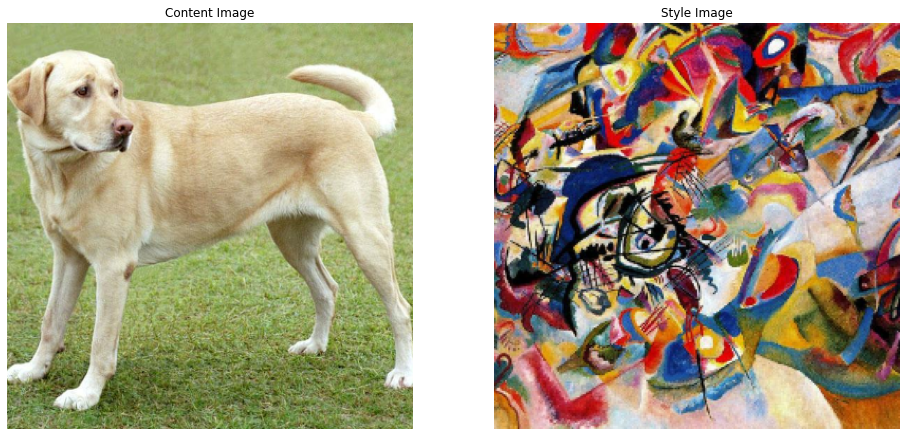

In [4]:
# visualize the content image and style image
content_img, style_img = model.return_input_images()

plt.figure(figsize=(16, 8)) 
plt.subplot(1, 2, 1)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')
plt.show()

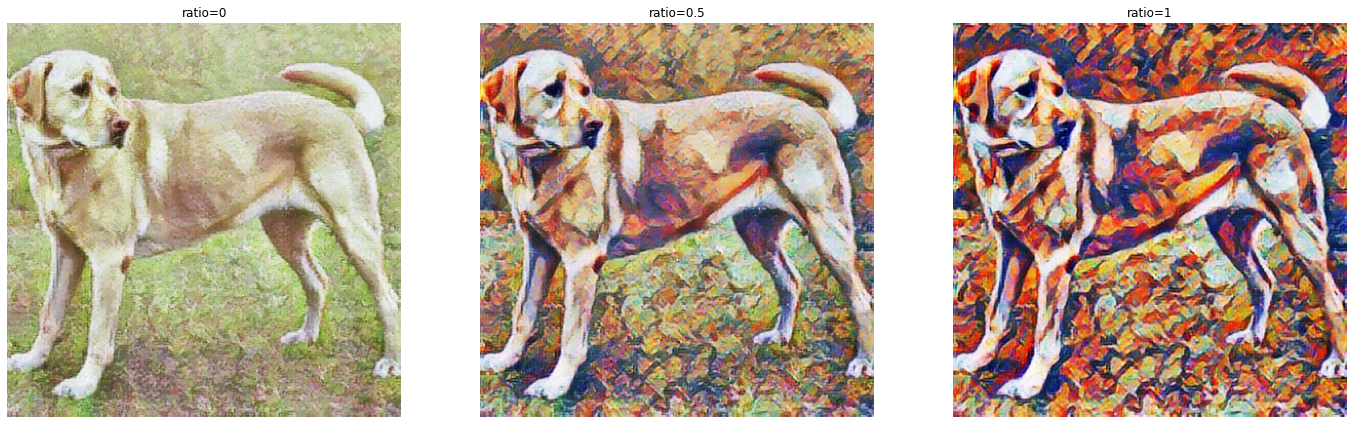

In [5]:
# blend the learned style and content style
plt.figure(figsize=(24, 8)) 

for i, value in enumerate([0, 0.5, 1]):
    plt.subplot(1, 3, i+1)
    stylized_image_blended = model.style_transform(value)
    plt.imshow(stylized_image_blended)
    plt.title(f'ratio={value}')
    plt.axis('off')
plt.show()

In [6]:
# get a content image and style image from local
content_path = 'content.jpg'
style_path = 'style.jpg'

# build our model
model = style_transfer_model(content_path, style_path)

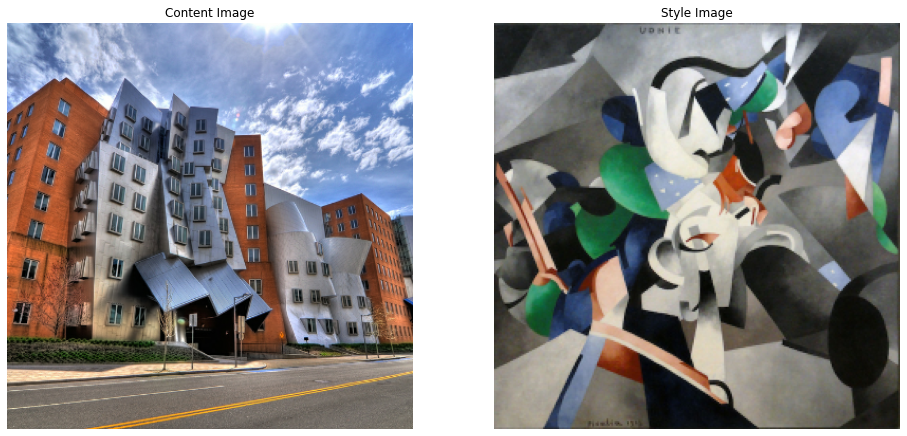

In [7]:
# visualize the content image and style image
content_img, style_img = model.return_input_images()

plt.figure(figsize=(16, 8)) 
plt.subplot(1, 2, 1)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')
plt.show()

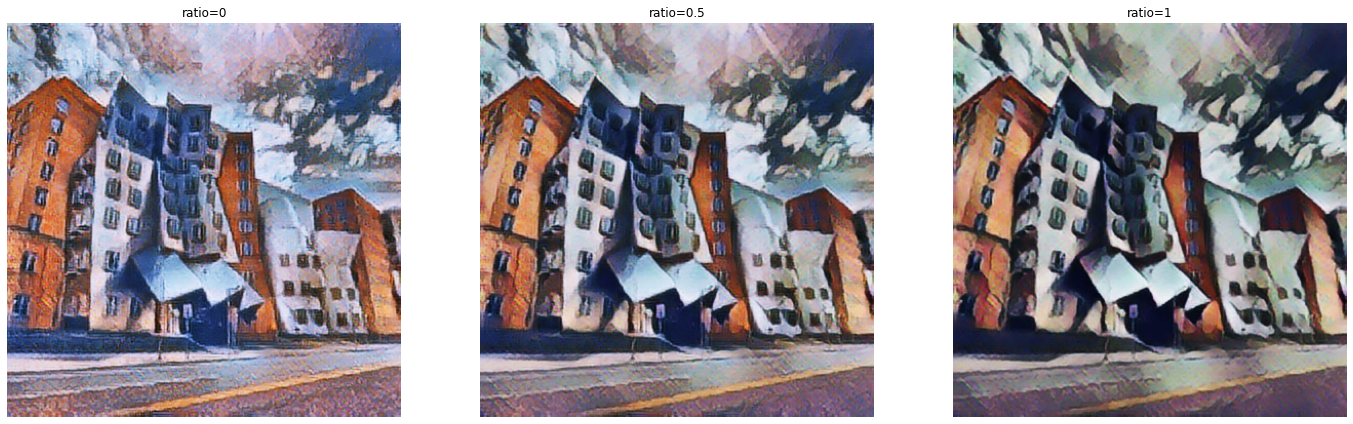

In [8]:
# blend the learned style and content style
plt.figure(figsize=(24, 8)) 
for i, value in enumerate([0, 0.5, 1]):
    plt.subplot(1, 3, i+1)
    stylized_image_blended = model.style_transform(value)
    plt.imshow(stylized_image_blended)
    plt.title(f'ratio={value}')
    plt.axis('off')
plt.show()

## Notice that:
Since we only feed one image for training, although it seems very well here, it fully depends on 'pre-built' part. So, for some unseen domain of styles, it works very poorly and needs us to training on more images.

### Let's see a "bad example", which has unseen style:

In [9]:
# get a content image and style image from local
content_path = 'unseen_content.jpg'
style_path = 'unseen_style.jpg'

# build our model
model = style_transfer_model(content_path, style_path)

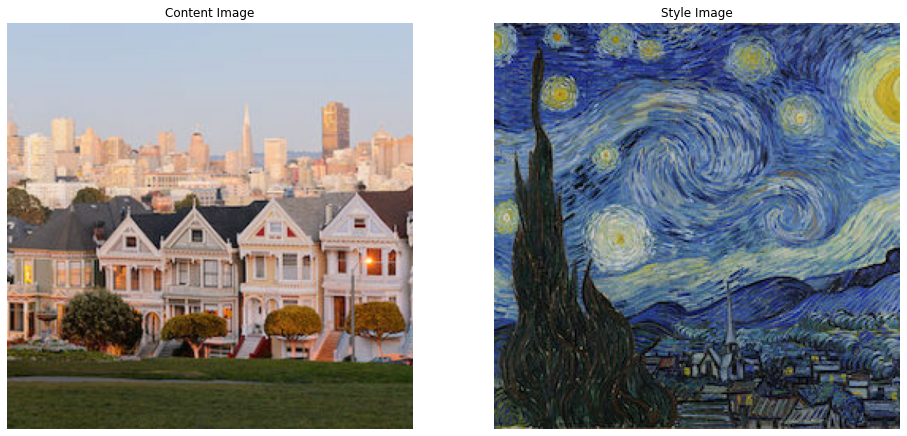

In [10]:
# visualize the content image and style image
content_img, style_img = model.return_input_images()

plt.figure(figsize=(16, 8)) 
plt.subplot(1, 2, 1)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')
plt.show()

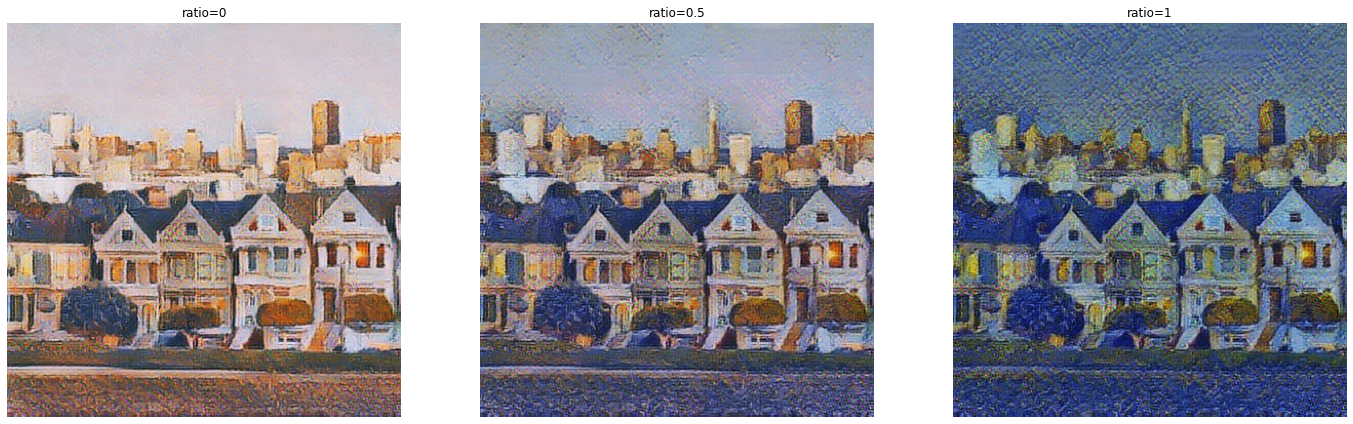

In [11]:
# blend the learned style and content style
plt.figure(figsize=(24, 8)) 
for i, value in enumerate([0, 0.5, 1]):
    plt.subplot(1, 3, i+1)
    stylized_image_blended = model.style_transform(value)
    plt.imshow(stylized_image_blended)
    plt.title(f'ratio={value}')
    plt.axis('off')
plt.show()

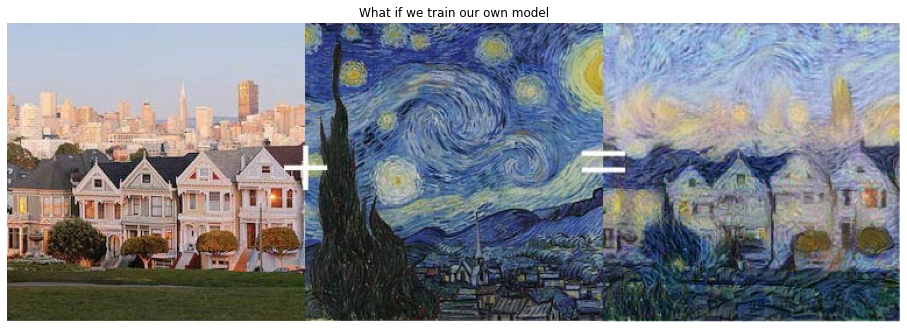

In [12]:
plt.figure(figsize=(16, 8)) 
img = plt.imread('StyleGraphic.jpg')
plt.imshow(img)
plt.title('What if we train our own model')
plt.axis('off')
plt.show()

# My central ideas:
### - If using Python, always looks for the pre-built libraries, functions, or models to simplify your work!
### - The power of codes is unbounded! Use your imagination and try to surprise everyone!
### - Coding is very interesting! Enjoy coding!

